In [1]:
from common import*
from sklearn.neighbors import KDTree
import matplotlib.pyplot as plt

In [2]:
# filter some (bugs?) from neurokit2
warnings.filterwarnings(action='ignore', message='Mean of empty slice')
warnings.filterwarnings(action='ignore', message='invalid value encountered in double_scalars')
warnings.filterwarnings(action='ignore', message='Too few peaks detected to compute the rate. Returning empty vector.')


In [3]:
# Definição do caminho para os arquivos de treino pré-processados
root = '/Users/juliastanciolipaiva/Documents/UFMG2020/Causalidade ML/TP-Causalidade/'
preprocess_folder = 'preprocess2'
train_folder = 'PreprocessedTrain'
batch = 0
path = root + preprocess_folder + os.sep + train_folder + os.sep + str(batch) + os.sep



In [4]:
# Definição do caminho para os arquivos de teste
folder = '/Users/juliastanciolipaiva/Documents/UFMG2020/Causalidade ML/TP-Causalidade/data/testData/'

In [5]:
with h5py.File(folder + 'ecg_tracings.hdf5') as f:
    M = np.array(f['tracings'])

In [7]:
def GetTestAge(i, dfAgeSex):
    return dfAgeSex.values[i][0]

In [8]:
def GetTestCoeffs(ecg):
    SAMPLE_RATE = 400
    w = ecg - ecg.mean()
    try:
        d = nk.ecg_delineate(w, sampling_rate=SAMPLE_RATE)[1]
    except:
        raise Exception('Neurokit não conseguiu delinear esse ECG')
    starts = d['ECG_P_Onsets']
    coeffs = []
    for j in range(len(starts) - 1):
        cur = starts[j]
        nxt = starts[j + 1]
        if math.isnan(cur) or math.isnan(nxt):
            print('Neurokit retornou nan')
            continue
            
        period = w[cur:nxt]
        if not len(period):
            print('Neurokit retornou período vazio')
            break
            
        coeffs.append(GetCoeff(period))
    if not len(coeffs):
        raise Exception('Neurokit não conseguiu encontrar batimentos nesse ECG')
    return coeffs

In [9]:
def counterfactual(person_id, counterfactual_age):
    original_ecg = M[person_id, :, ELETRODO_IDX]
    coeffs = GetTestCoeffs(original_ecg)
    start = path + str(counterfactual_age) + os.sep
    mappings = np.load(start + 'mappings.npy')
    ecgs = np.load(start + 'ecgs.npy')
    ondas = np.load(start + 'ondas.npy')
    tree = KDTree(ondas)
    dist, ind = tree.query(coeffs)
    gIdx = dist.argmin()
    idxClosestOnda = ind[gIdx][0]
    ecgOrgRow = mappings[idxClosestOnda]
    ecgClosest = ecgs[ecgOrgRow]
    return ecgClosest

In [13]:
dfAgeSex = pd.read_csv(folder + 'attributes.csv')
pessoa = 0
age = GetTestAge(pessoa, dfAgeSex)
print(age)

34


In [20]:
counterfactual_age = age+26
new_ecg = counterfactual(pessoa,counterfactual_age)

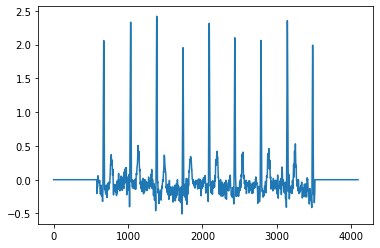

In [21]:
plt.plot(new_ecg)
plt.show()